In [75]:
import numpy as np
import pickle
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm

In [340]:
import os
BASE_PATH = './dataset/T_Shirt_all/'

### modelの用意

In [73]:
from keras.models import load_model
model_epoch = 20
con_embNet = load_model('./model/T_Shirt/krasser/con_emb_e{}.h5'.format(model_epoch))
shop_embNet = load_model('./model/T_Shirt/krasser/shop_emb_e{}.h5'.format(model_epoch))

/home/inouelab/.conda/envs/zukapy35/lib/python3.5/site-packages/keras/engine/saving.py:269: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


### 既に分割したtestデータを呼んでくる

In [335]:
f = open("./test_ids.txt","rb")
test_ids = pickle.load(f)

In [336]:
test_ids[:5]

['id_00010696', 'id_00023825', 'id_00017789', 'id_00022720', 'id_00003304']

In [7]:
# 自作moduleのimport
import datagen

In [8]:
test_pairs = datagen.get_test_pairs(test_ids,BASE_PATH,seed_num=0)

100%|██████████| 2032/2032 [00:00<00:00, 3990.24it/s]


In [9]:
test_pairs[0]

[10696,
 ['./T_Shirt_all/id_00010696/comsumer_01.jpg',
  './T_Shirt_all/id_00010696/shop_01.jpg']]

In [10]:
print("test_pairsの中身 : [product_id,['con_path','shop_path']] \ntest_pairs[0] : %s" %test_pairs[0])

test_pairsの中身 : [product_id,['con_path','shop_path']] 
test_pairs[0] : [10696, ['./T_Shirt_all/id_00010696/comsumer_01.jpg', './T_Shirt_all/id_00010696/shop_01.jpg']]


In [11]:
test_pairs[0][1][1]

'./T_Shirt_all/id_00010696/shop_01.jpg'

In [12]:
import pickle
f = open('test_pairs.txt', 'wb')
pickle.dump(test_pairs, f)

### 検索画像プール(gallery)作成
- idをintに直す必要がある?gallery=[id(string),[np.ndarray]]にしたらどう？
- とりあえずtestだけのgalleryでやってみよう

In [13]:
aaa =[['id_0000000',np.zeros(10)] ,['id_0000001',np.ones(10)]]
aaa

[['id_0000000', array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])],
 ['id_0000001', array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])]]

In [14]:
gallery = []
for tp in test_pairs:
    gallery.append([tp[0],tp[1][1]])
gallery[0]

[10696, './T_Shirt_all/id_00010696/shop_01.jpg']

In [15]:
len(gallery)

2032

画像をベクトルの形に埋め込んでいく

In [76]:
vec_length=100
# 予め入れ物を用意or後でappend
emb_vecs = np.zeros((len(gallery),vec_length))
ans_ids = np.zeros(len(gallery))
# gallery=[id,img_path]
for i,g in enumerate(tqdm(gallery)):
    img =np.array(Image.open(g[1]).resize((128,128)).convert('RGB'))/255.
    ans_ids[i] = g[0]
    emb_vecs[i] = shop_embNet.predict(np.expand_dims(img,axis=0))[0] # need [0] because of expanding dimension -> [[]]

100%|██████████| 2032/2032 [12:06<00:00,  2.80it/s]


ユークリッド距離を計算する関数distance

In [77]:
def distance(emb1, emb2):
    return np.sum(np.square(emb1 - emb2))

In [78]:
query_ids = np.zeros(len(test_pairs))
for i,tp in enumerate(test_pairs):
    query_ids[i] = tp[0]
    
query_ids[:5]

array([10696., 23825., 17789., 22720.,  3304.])

- ~~idxsのところ実装ミスの可能性~~<br>
- N=50として予めtopN_id_listを作成しておけばスライスによって任意のtopKを算出できる

In [79]:
# N = 20

# topN_id_list=[] # [[query1->上位20個のid],...,[queryK->上位20個のid]]
# for tp in test_pairs:
#     img = np.array(Image.open(tp[1][0]).resize((128,128)).convert('RGB'))/255.
#     test = shop_embNet.predict(np.expand_dims(img.astype(np.float32),axis=0))[0]
# #     test = con_embNet.predict(np.expand_dims(img.astype(np.float32),axis=0))[0]

#     # calc order
#     similarities = np.zeros(len(emb_vecs))
#     for i,emb_vec in enumerate(emb_vecs):
#         similarities[i] = distance(test,emb_vec) # retrieve from all the images
#     idxs = similarities.argsort() # ascending order/ argsort() returns indexes
#     topN_id_list.append(ans_ids[idxs[:N]]) # append ids

In [82]:
N = 50

topN_id_list=[] # [[query1->上位20個のid],...,[queryK->上位20個のid]]
for tp in tqdm(test_pairs):
    img = np.array(Image.open(tp[1][0]).resize((128,128)).convert('RGB'))/255.
    test = shop_embNet.predict(np.expand_dims(img.astype(np.float32),axis=0))[0]
#     test = con_embNet.predict(np.expand_dims(img.astype(np.float32),axis=0))[0]

    # calc order
    similarities = np.zeros(len(emb_vecs))
    for i,emb_vec in enumerate(emb_vecs):
        similarities[i] = distance(test,emb_vec) # retrieve from all the images
    idxs = similarities.argsort() # ascending order/ argsort() returns indexes
    topN_id_list.append(ans_ids[idxs[:N]]) # append ids

100%|██████████| 2032/2032 [06:35<00:00,  5.14it/s]


In [83]:
topN_id_list[0]

array([14640., 17408.,  8628., 25742.,  4365., 27079., 26253., 27401.,
        9561., 14564., 16115., 16441.,  4837.,  9026.,  9684., 23235.,
        5942., 21702., 16631., 26267., 21715., 20227., 16828., 26058.,
        7805., 33059., 19809., 26715., 18198., 14298., 20993., 20370.,
       27011., 26240., 24127.,  9159., 20948., 17230., 17360., 14060.,
       19923., 19359., 11046., 15105., 11323., 10576., 23763., 11860.,
       20831., 18902.])

cf. bench mark(FashionNet): 0.18

In [323]:
lim = 50
cnt = 0
top20_ids = []
topN_ids = []
topN_idxs = []
for i,(ans_id,topN_id) in enumerate(zip(ans_ids,topN_id_list)):
    if ans_id in topN_id[:lim]:
        cnt+=1
        topN_ids.append(ans_id)
        topN_idxs.append(i)
    if ans_id in topN_id[:20]:
#         top20_ids.append(i)
        top20_ids.append(ans_id)
#         print(ans_id)
print("{0}-top:{1}".format(lim,cnt/len(test_ids)))
# print(top20_ids)

50-top:0.265748031496063


In [98]:
type(topN_idxs)

list

In [324]:
def calc_topk_vals(k_values,ans_ids,topN_id_list,length):
    topk_vals = []
    for k in k_values:
        cnt = 0
        for i,(ans_id,topN_id) in enumerate(zip(ans_ids,topN_id_list)):
            if ans_id in topN_id[:k]:
                cnt+=1
        topk_vals.append(cnt/length)
    return topk_vals

In [325]:
mynet=calc_topk_vals(x,ans_ids,topN_id_list,len(test_ids))

In [326]:
mynet

[0.01328740157480315,
 0.05265748031496063,
 0.08661417322834646,
 0.140748031496063,
 0.18503937007874016,
 0.2283464566929134,
 0.265748031496063]

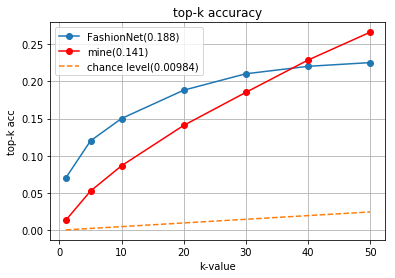

In [330]:
x=[1,5,10,20,30,40,50]
fashionNet=[0.07,0.12,0.15,0.188,0.21,0.22,0.225]
# mynet=[0.011,0.0325,0.055,0.0885,0.11958,0.147,0.166]
mynet=calc_topk_vals(x,ans_ids,topN_id_list,len(test_ids))
chancelv=np.array(x)/len(test_pairs)

plt.plot(x,fashionNet,marker='o',label='FashionNet(0.188)')
plt.plot(x,mynet,c='r',marker='o',label='mine({})'.format(round(mynet[3],3)))
plt.plot(x,chancelv,linestyle='dashed',label='chance level(0.00984)')
plt.legend(loc='upper left')#,bbox_to_anchor=(1, 0.2))
plt.grid('True')
plt.title("top-k accuracy")
plt.xlabel("k-value")
plt.ylabel("top-k acc")

plt.savefig('./result_img/result_epoch{}.png'.format(model_epoch))

予測するときにresizeしているだけで元の画像を(128,128)にしているわけではないので比率を保って表示できる。

queryと結果のidが同じときに枠線の色を変えたい

In [263]:
len(topN_idxs)

107

In [314]:
goodidx = np.array(topN_idxs[10:30])
print(goodidx)
# リストのスライスのため
from operator import itemgetter
results = itemgetter(*goodidx)(test_pairs)

[173 200 210 257 267 284 289 299 324 333 346 365 377 383 389 395 409 423
 428 469]


In [315]:
# import visualize

In [316]:
def show_correct(img):
    img = np.array(img)
    img = np.array([np.pad(img[:,:,0], (8,8), 'constant', constant_values=(255,255)),np.pad(img[:,:,1], (8,8), 'constant',constant_values=(0,0)),np.pad(img[:,:,2], (8,8), 'constant',constant_values=(0,0))])
    plt.imshow(img.transpose(1,2,0))

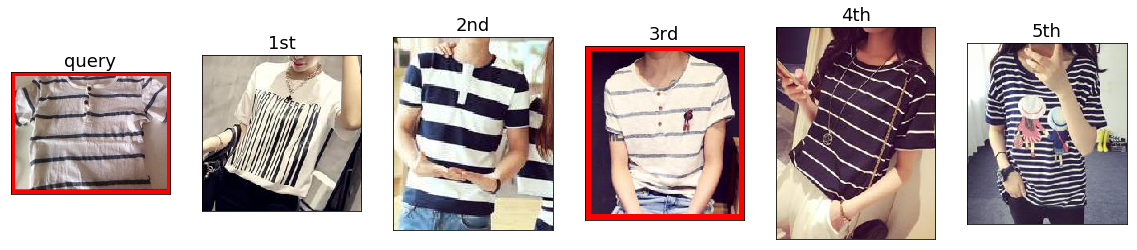

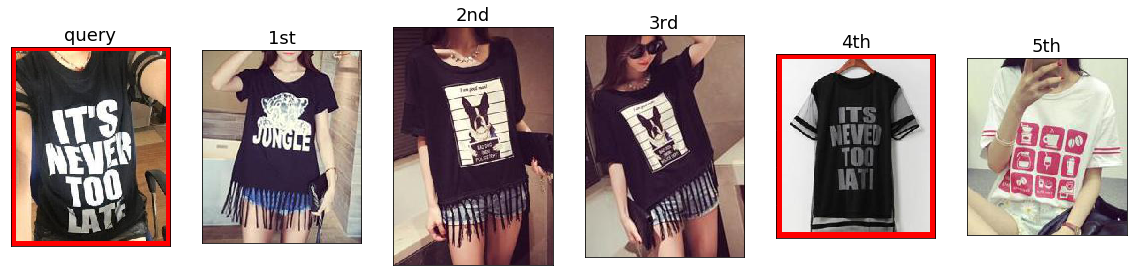

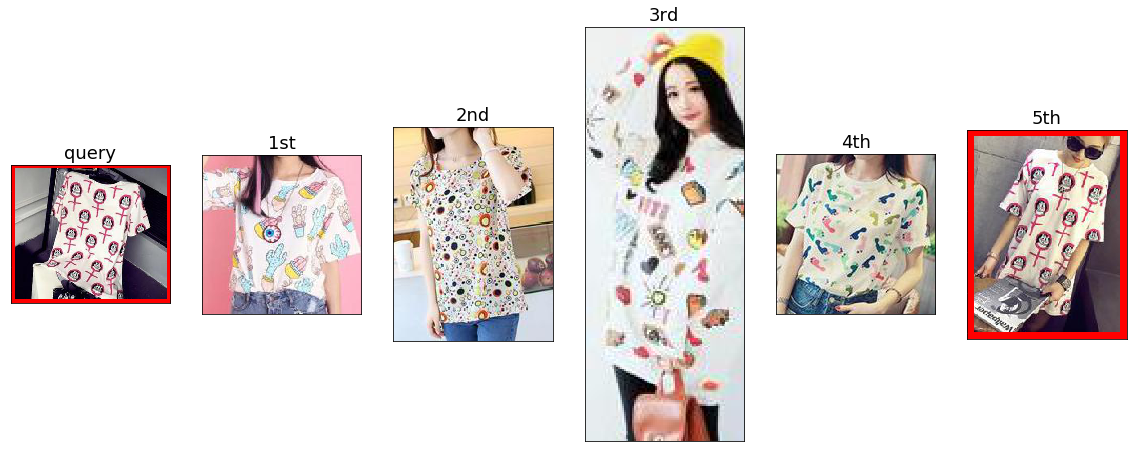

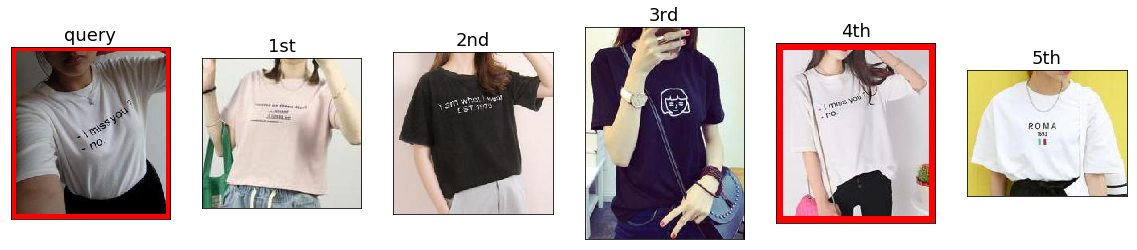

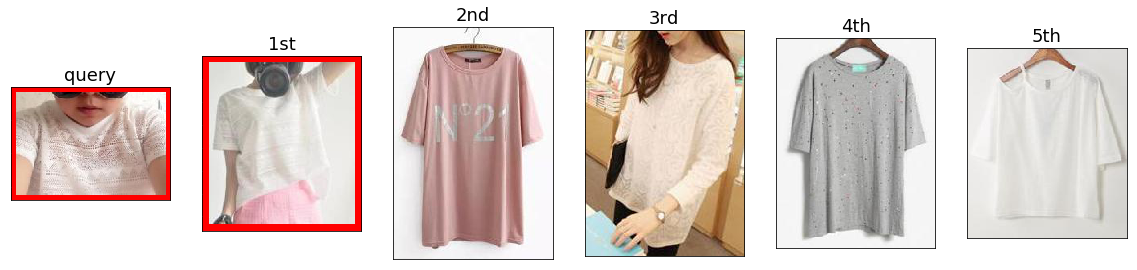

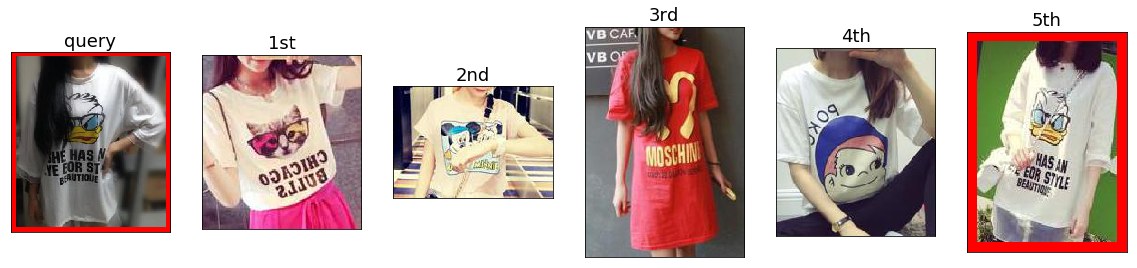

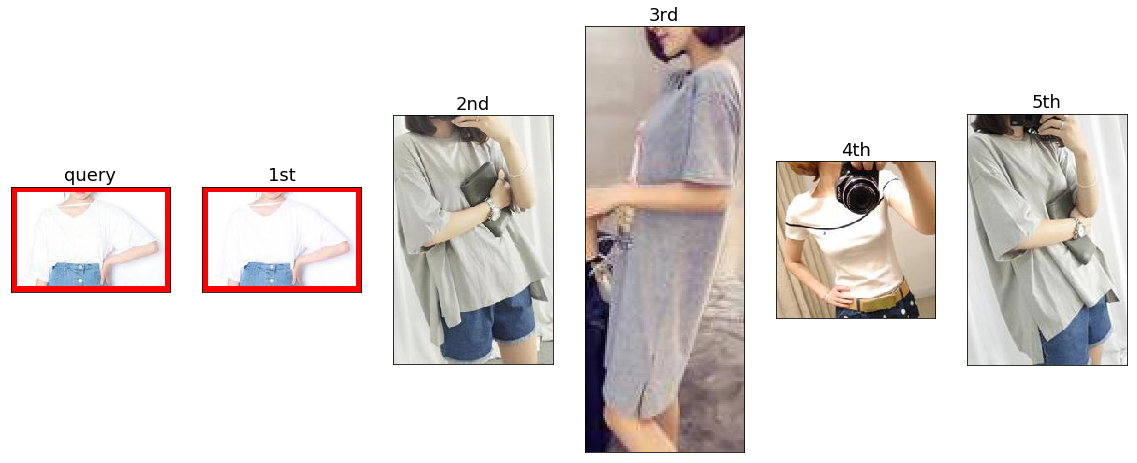

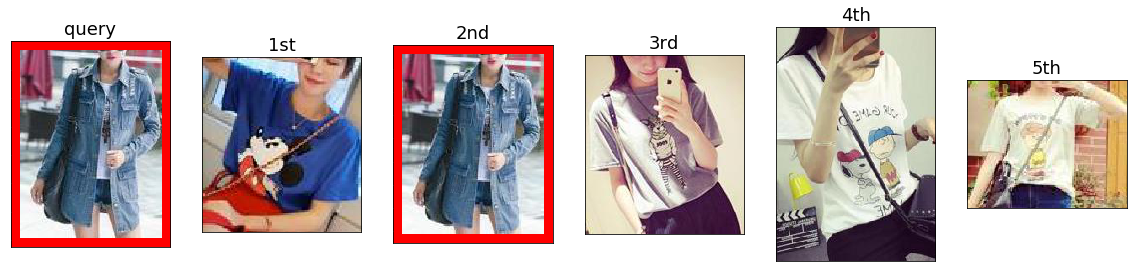

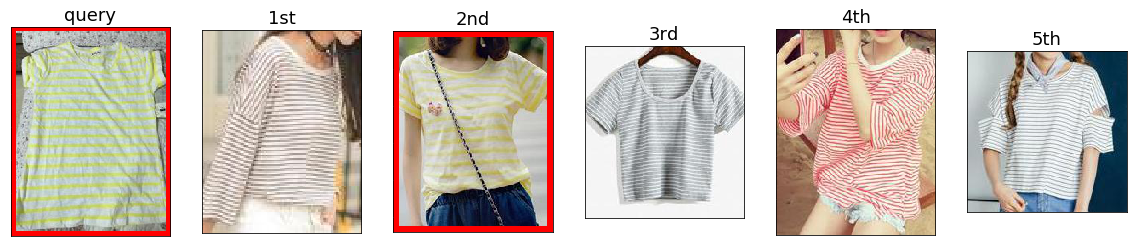

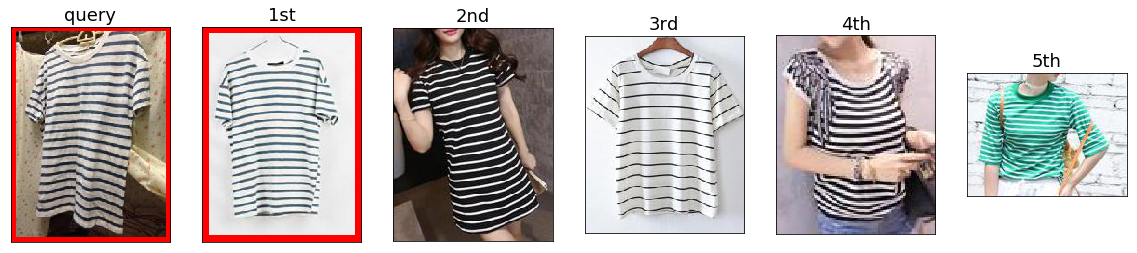

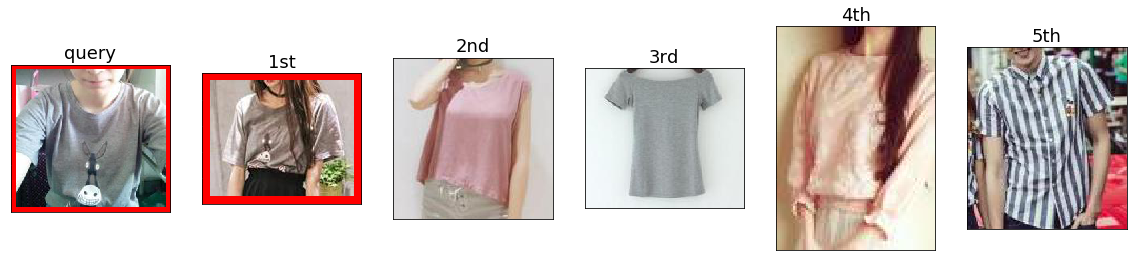

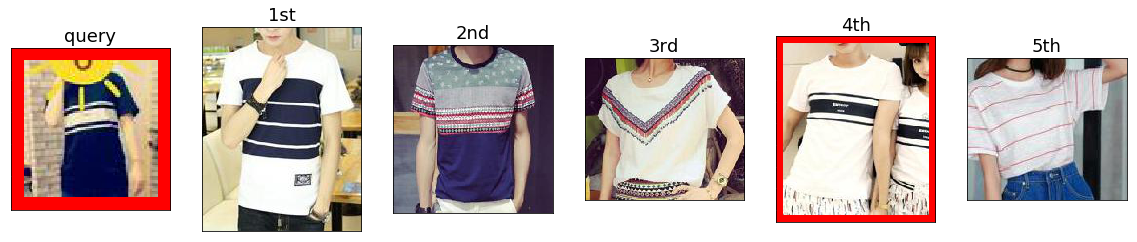

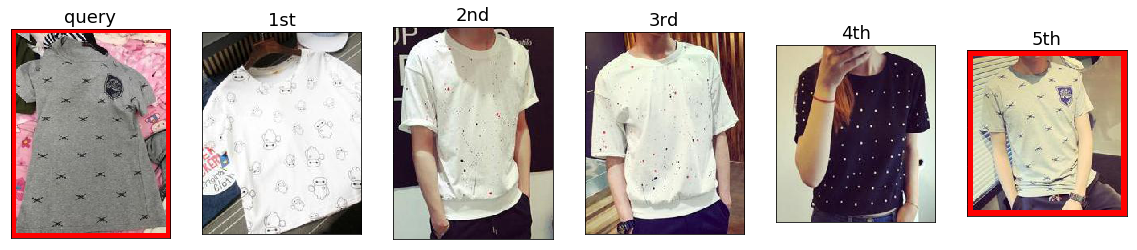

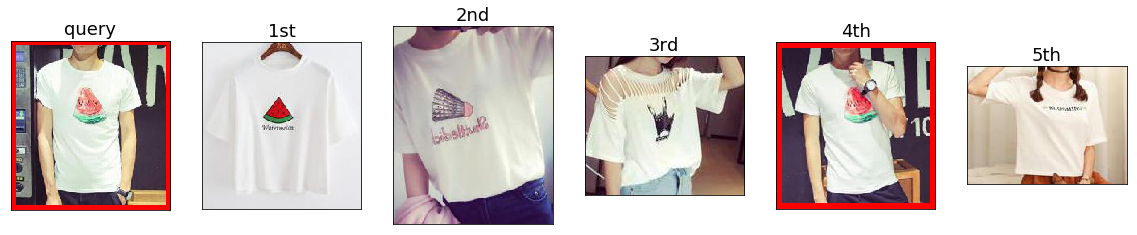

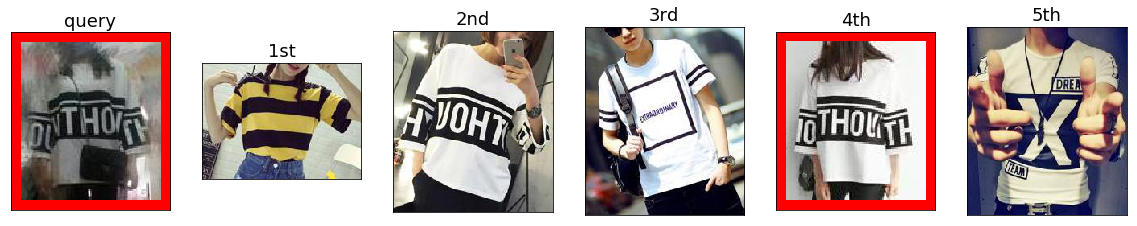

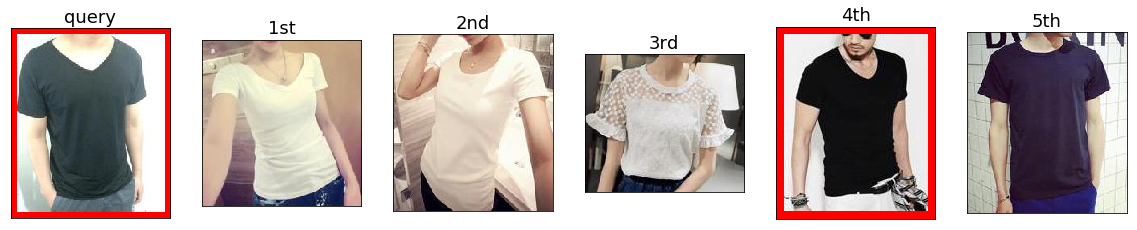

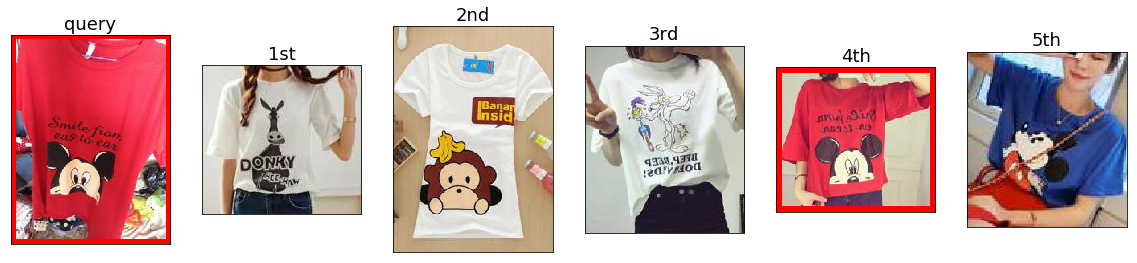

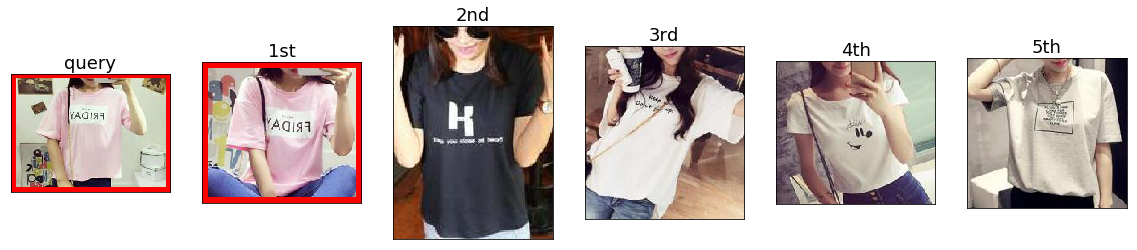

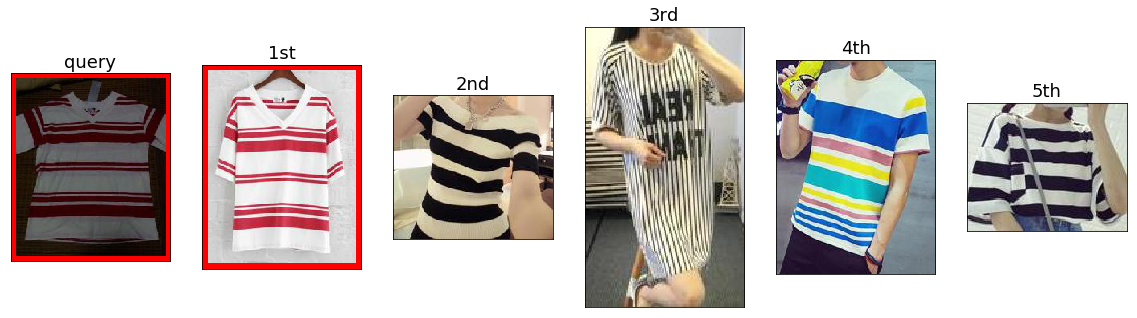

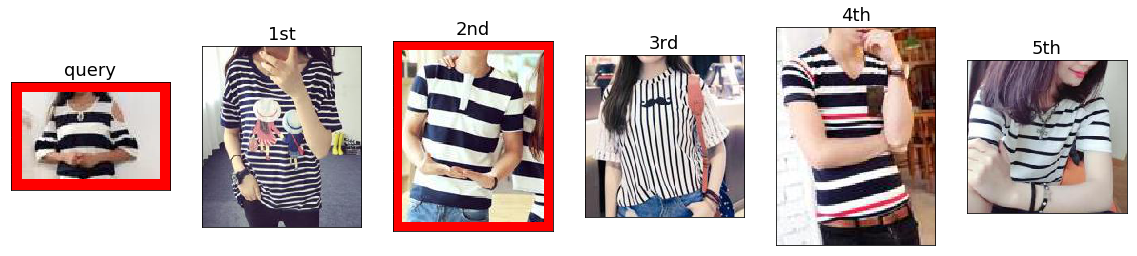

In [317]:
imheight,imwidth=128,128
num = 5
for tp in results:
    # show query
    fig = plt.figure(figsize=(20,10))
    plt.subplot(1,6,1)
    plt.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False)
    plt.tick_params(color='white')
    raw_img = Image.open(tp[1][0])
    img =np.array(raw_img.resize((128,128)).convert('RGB'))/255.
    test = shop_embNet.predict(np.expand_dims(img.astype(np.float32),axis=0))[0]
    plt.title('query',fontsize=18)
    show_correct(raw_img)

    # calc order
    similarities = np.zeros(len(emb_vecs))
    for i,emb_vec in enumerate(emb_vecs):
        similarities[i] = distance(test,emb_vec)
    idxs = similarities.argsort() #ascending order b.c. smaller is better/ get the index array in ascending order
    
    # show nearest
    plt.subplot(1,6,2)
    plt.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False)
    plt.tick_params(color='white')
    nearest = Image.open(gallery[idxs[0]][1])
    plt.title('1st',fontsize=18)
    if gallery[idxs[0]][0] == tp[0]:
        show_correct(nearest)
    else:
        plt.imshow(nearest)
    
    # show 2nd
    plt.subplot(1,6,3)
    plt.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False)
    plt.tick_params(color='white')
    second =  Image.open(gallery[idxs[1]][1])

    if gallery[idxs[1]][0] == tp[0]:
        show_correct(second)
    else:
        plt.imshow(second)
        
    plt.title('2nd',fontsize=18)
        
    
    # show 3rd
    plt.subplot(1,6,4)
    plt.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False)
    plt.tick_params(color='white')
    third =  Image.open(gallery[idxs[2]][1])
    plt.title('3rd',fontsize=18)
    if gallery[idxs[2]][0] == tp[0]:
        show_correct(third)
    else:
        plt.imshow(third)
    
    # show 4th
    plt.subplot(1,6,5)
    plt.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False)
    plt.tick_params(color='white')
    fourth =  Image.open(gallery[idxs[3]][1])
    plt.title('4th',fontsize=18)
    if gallery[idxs[3]][0] == tp[0]:
        show_correct(fourth)
    else:
        plt.imshow(fourth)
    
    
        # show 5th
    plt.subplot(1,6,6)
    plt.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False)
    plt.tick_params(color='white')
    fifth =  Image.open(gallery[idxs[4]][1])
    plt.title('5th',fontsize=18)
    if gallery[idxs[4]][0] == tp[0]:
        show_correct(fifth)
    else:
        plt.imshow(fifth)
    
    
    plt.savefig('./result_img/{}_result_id{}.png'.format(model_epoch,tp[0]),bbox_inches="tight")

In [30]:
def get_concat_v(im1, im2):
    dst = Image.new('RGB', (im1.width, im1.height + im2.height))
    dst.paste(im1, (0, 0))
    dst.paste(im2, (0, im1.height))
    return dst

In [36]:
imgs = os.listdir('./result_img/')
im1= Image.open('./result_img/'+imgs[0])
im2= Image.open('./result_img/'+imgs[1])
dst1 = get_concat_v(im1,im2)
im1= Image.open('./result_img/'+imgs[2])
im2= Image.open('./result_img/'+imgs[3])
dst2 = get_concat_v(im1,im2)
im1= Image.open('./result_img/'+imgs[4])
im2= Image.open('./result_img/'+imgs[5])
dst3 = get_concat_v(im1,im2)
im1= Image.open('./result_img/'+imgs[6])
im2= Image.open('./result_img/'+imgs[7])
dst4 = get_concat_v(im1,im2)
im1= Image.open('./result_img/'+imgs[8])
im2= Image.open('./result_img/'+imgs[9])
dst5 = get_concat_v(im1,im2)

dst6 = get_concat_v(dst1,dst2)
dst7 = get_concat_v(dst3,dst4)
dst8 = get_concat_v(dst6,dst7)
get_concat_v(dst8,dst5).save('./result_img/concat.png')

In [41]:
20/len(test_pairs)

0.00984251968503937

In [241]:
img = np.array(Image.open(test_pairs[1][1][0]))
print(img.shape)

(243, 210, 3)


In [242]:
img[:,:,1].shape

(243, 210)

In [243]:
img =np.array([np.pad(img[:,:,0], (3,3), 'constant', constant_values=(200,200)),np.pad(img[:,:,1], (3,3), 'constant',constant_values=(0,0)),np.pad(img[:,:,2], (3,3), 'constant',constant_values=(0,0))])

In [244]:
img.shape

(3, 249, 216)

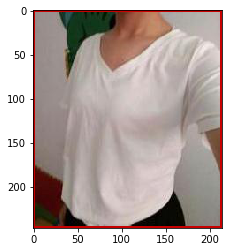

In [240]:
plt.imshow(img.transpose(1,2,0))

In [260]:
test_pairs[299]

[8613,
 ['./T_Shirt_all/id_00008613/comsumer_01.jpg',
  './T_Shirt_all/id_00008613/shop_01.jpg']]

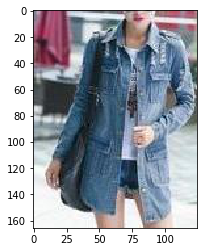

In [261]:
plt.imshow(Image.open(test_pairs[299][1][0]))

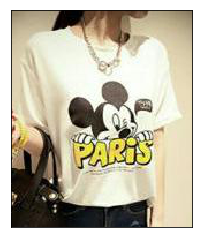

In [277]:
    plt.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False)
    plt.tick_params(color='white')
plt.imshow(Image.open(test_pairs[5][1][0]))

In [274]:
import math
1-(math.factorial(1999)/(math.factorial(1999-20))*math.pow(1/2000.,20))

0.10000007489032958

In [279]:
20/len(test_pairs)

0.00984251968503937

In [350]:
def get_shopimgs(ids,BASE_PATH):
    shop_img_list=[]
    for id_ in ids:
        file_paths = sorted([BASE_PATH+id_+'/'+x for x in os.listdir(BASE_PATH+id_)])
        shop_paths = sorted([x for x in file_paths if 'shop' in x ])
        for shop_path in shop_paths:
            img = np.array(Image.open(shop_path).resize((128,128)).convert('RGB'))/255.
            emb = shop_embNet.predict(np.expand_dims(img.astype(np.float32),axis=0))[0]
            shop_img_list.append([id_,shop_path,emb])
    return shop_img_list

In [351]:
a = get_shopimgs(test_ids[:5],BASE_PATH)

In [352]:
a[0]

['id_00010696',
 './dataset/T_Shirt_all/id_00010696/shop_01.jpg',
 array([ 0.33196932, -0.        , -0.        ,  0.05118379, -0.        ,
        -0.        , -0.        , -0.        , -0.        , -0.        ,
        -0.        , -0.        ,  0.36122134, -0.        ,  0.07608534,
         0.13766111, -0.        , -0.        , -0.        , -0.        ,
        -0.        ,  0.07716542, -0.        , -0.        , -0.        ,
         0.04976363, -0.        , -0.        , -0.        , -0.        ,
        -0.        , -0.        , -0.        , -0.        , -0.        ,
         0.08355188,  0.18005942, -0.        , -0.        ,  0.25081095,
         0.00918872, -0.        , -0.        , -0.        , -0.        ,
         0.00807675, -0.        ,  0.05062011, -0.        , -0.        ,
        -0.        , -0.        ,  0.37685952, -0.        , -0.        ,
        -0.        , -0.        , -0.        , -0.        , -0.        ,
        -0.        , -0.        ,  0.16582282, -0.        